<a href="https://colab.research.google.com/github/LeonimerMelo/GANs/blob/main/MNIST_digits_MLP_GAN_v7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Redes Generativas Adversariais (GANs)
As **Generative Adversarial Networks (GANs)** são um novo tipo de arquitetura neural introduzida por Ian Goodfellow e outros pesquisadores da Universidade de Montreal em 2014. A característica mais notável das GANs é sua capacidade de criar imagens, vídeos, músicas e textos hiper-realistas.  

Esses modelos de redes neurais realmente criam novos conteúdos que não existiam antes — novas pessoas, novos objetos, uma nova realidade, como mágica! Treinamos esses modelos em um conjunto de dados de um domínio específico, e então eles criam novas imagens com objetos do mesmo domínio que parecem muito próximos dos dados reais.  

Veja exemplos de geradores de rostos com GANs no site [This Person Does Not Exist](https://thispersondoesnotexist.com/). Ele usa uma tecnologia especial chamada **StyleGAN3**, que funciona como um artista no mundo digital. Ela está aqui para criar rostos que parecem tão reais que você pode pensar que são pessoas de verdade — mas não são! Esses rostos são todos feitos por um computador superinteligente, usando suas habilidades para criar indivíduos detalhados e únicos que você não encontrará em nenhum outro lugar.  

Ao aprender a imitar qualquer distribuição de dados, os computadores podem ser ensinados a criar mundos semelhantes ao nosso em qualquer domínio: imagens, música, fala, prosa, etc.

Como você pode ver no diagrama de arquitetura, uma GAN segue os seguintes passos:  

1. O **gerador** recebe números aleatórios e retorna uma imagem.  
2. Essa imagem gerada é enviada ao **discriminador** junto com um fluxo de imagens reais, extraídas do conjunto de dados verdadeiro (ground-truth).  
3. O **discriminador** recebe tanto as imagens reais quanto as falsas e retorna probabilidades: números entre 0 e 1, onde 1 representa uma previsão de autenticidade (imagem real) e 0 representa uma previsão de falsidade (imagem falsa).  

Essa interação entre o gerador e o discriminador é o cerne do funcionamento das GANs, onde o gerador tenta criar imagens cada vez mais realistas para "enganar" o discriminador, enquanto o discriminador tenta se tornar cada vez melhor em distinguir entre imagens reais e falsas. Esse processo competitivo leva à geração de conteúdos altamente realistas.

<center><img src='https://drive.google.com/uc?id=18FoExFcG3DZhMfFt6ys4AsrqpWuq7jCR' width=900></center>

A arquitetura da GAN é composta por redes **geradoras** e **discriminadoras**. Observe que a rede discriminadora é uma CNN (Rede Neural Convolucional) típica, na qual as camadas convolucionais diminuem de tamanho até chegarem à camada achatada (flattened layer). Por outro lado, a rede geradora é uma CNN invertida que começa com um vetor achatado: as camadas convolucionais aumentam de tamanho até formar a dimensão das imagens de entrada.  

Essa estrutura permite que o gerador transforme um vetor de números aleatórios em uma imagem com as mesmas dimensões das imagens reais, enquanto o discriminador analisa as imagens (reais e falsas) e as classifica como autênticas ou falsas. Essa dinâmica entre as duas redes é o que impulsiona o aprendizado e a geração de conteúdos realistas.

## O modelo Discriminador  
O objetivo do discriminador é prever se uma imagem é real ou falsa. Esse é um problema típico de classificação supervisionada, então podemos usar uma rede de classificação tradicional. A rede consiste em camadas convolucionais empilhadas, seguidas por uma camada densa de saída com uma função de ativação sigmoide. Usamos a função de ativação sigmoide porque esse é um problema de classificação binária: o objetivo da rede é gerar valores de probabilidade de previsão que variam entre 0 e 1, onde 0 significa que a imagem gerada pelo gerador é falsa e 1 significa que é 100% real.  

Essa estrutura permite que o discriminador avalie a autenticidade das imagens, fornecendo feedback ao gerador para que ele possa melhorar sua capacidade de criar imagens realistas. A competição entre o gerador e o discriminador é o que impulsiona o aprimoramento contínuo de ambos os modelos.

<center><img src='https://drive.google.com/uc?id=1lK04uhbNwlbuf2s7pOFFQO3jAOMGoXeI' width=900></center>

O discriminador é uma rede com modelo de classificação já bem compreendido. Treinar o discriminador é bastante direto. Alimentamos o discriminador com imagens rotuladas: falsas (ou geradas) e reais. As imagens reais vêm do conjunto de dados de treinamento, e as imagens falsas são a saída do modelo gerador.  

Durante o treinamento:  
1. **Imagens reais**: São rotuladas como "1" (100% reais) e usadas para ensinar o discriminador a reconhecer características autênticas.  
2. **Imagens falsas**: São rotuladas como "0" (falsas) e usadas para ensinar o discriminador a identificar conteúdos gerados pelo gerador.  

Esse processo de treinamento ajuda o discriminador a se tornar cada vez mais preciso em distinguir entre imagens reais e falsas. Ao mesmo tempo, o gerador é treinado para criar imagens que "enganem" o discriminador, levando a uma melhoria contínua de ambos os modelos. Essa interação competitiva é a essência das GANs.

##A Simple Generative Adversarial Network with Keras

In [1]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, LeakyReLU, UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras import backend
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

Before you can start building the discriminator and generator, you should first gather and pre-process the data. You will use the popular MNIST dataset which has a set of images of single digits ranging from 0 to 9.

Note that the `mnist.load_data()` is part of Keras and allows you to easily import the MNIST dataset into your workspace.

In [2]:
# Load MNIST digits dataset
#(x_train, y_train), (x_test, y_test) = mnist.load_data()
(x_train, _), (x_test, _) = mnist.load_data()
print('x train shape:', x_train.shape)
# utilizo todo o banco de dados para treinamento (x_train)
x_train = np.concatenate([x_train, x_test])
print('x train shape:', x_train.shape)
print('min', x_train.min(), 'max', x_train.max())
# normalize our inputs to be in the range[-1, 1]
x_train = (x_train.astype(np.float32) - 127.5)/127.5
print('x train shape:', x_train.shape)
print('min', x_train.min(), 'max', x_train.max())
# convert x_train with a shape of (70000, 28, 28) to (70000, 784) so we have 784 columns per row
x_train = x_train.reshape(x_train.shape[0], 784)
print('x train shape:', x_train.shape)
print('min', x_train.min(), 'max', x_train.max())

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
x train shape: (60000, 28, 28)
x train shape: (70000, 28, 28)
min 0 max 255
x train shape: (70000, 28, 28)
min -1.0 max 1.0
x train shape: (70000, 784)
min -1.0 max 1.0


Now, you can create your generator and discriminator networks. Initially you can use the Adam optimizer for both networks. For both the generator and discriminator, you will create a neural network with three hidden layers with the activation function being the Leaky Relu. You should also add dropout layers for the discriminator to improve its robustness on unseen images.

## O Discriminador  
Aqui, desenvolvemos uma rede neural feedforward simples para o Discriminador, onde passaremos o tamanho de uma imagem. A função de ativação usada é a **Leaky ReLU** (você já conhece o motivo para isso), e a função **sigmoid** é usada na camada de saída para problemas de classificação binária, a fim de classificar as imagens como reais ou falsas.  

Agora, vamos implementar a rede do discriminador no Keras. Neste trecho de código, o formato da imagem de entrada é 28 × 28, redimensionado para um vetor de 784 elementos.  

Aqui está um exemplo de como isso pode ser implementado:

In [3]:
#@title Implementing the discriminator model
# inicializa a sessão
backend.clear_session()
discriminator = Sequential(name='Discriminator')
discriminator.add(Input(shape=(28*28,)))
discriminator.add(Dense(1024))
# discriminator.add(Dense(1024, input_dim=784))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))

discriminator.add(Dense(512))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))

discriminator.add(Dense(256))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))

discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer='rmsprop')
#discriminator.compile(loss='binary_crossentropy', optimizer='adam')
#opt = Adam(lr=0.0002, beta_1=0.5)
#discriminator.compile(loss='binary_crossentropy', optimizer=opt)

discriminator.summary()

Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 1024)                │         803,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,460,225 (5.57 MB)

 Trainable params: 1,460,225 (5.57 MB)

 Non-trainable params: 0 (0.00 B)

### Explicação do código:
1. **Entrada**: A imagem de 28x28 pixels é achatada em um vetor de 784 elementos.
2. **Camadas densas**: São usadas camadas densas (fully connected) com ativação **Leaky ReLU** para evitar o problema de neurônios "mortos" que pode ocorrer com a ReLU tradicional.
3. **Saída**: A camada de saída tem 1 neurônio com ativação **sigmoid**, que retorna uma probabilidade entre 0 (falsa) e 1 (real).
4. **Compilação**: O modelo é compilado com a função de perda `binary_crossentropy`, adequada para problemas de classificação binária, e o otimizador **Adam** ou **RMSprop** é usado para ajustar os pesos.

Essa é uma implementação básica do discriminador, que pode ser aprimorada com técnicas como dropout, normalização em lote (batch normalization) ou camadas convolucionais, dependendo da complexidade do problema.

#### Por que usamos Leaky ReLU?  
A Leaky ReLU ajuda o gradiente a fluir mais facilmente pela arquitetura da rede neural.  

- A função de ativação **ReLU** tradicional retorna apenas o valor máximo entre a entrada e zero. Se usarmos ReLU, há uma chance de a rede ficar presa em um estado conhecido como **Dying ReLU** (ReLU "morta"). Se isso acontecer, a rede produzirá apenas zero para todas as saídas, o que impede o aprendizado.  
- Nosso objetivo é obter o valor do gradiente do Discriminador para fazer o Gerador funcionar. Se a rede ficar presa no estado Dying ReLU, o aprendizado não ocorrerá.  
- A **Leaky ReLU** usa um parâmetro chamado **alpha** para controlar valores negativos, permitindo que eles passem pela rede, embora atenuados. Se a entrada for positiva, ela retornará o valor positivo. Se for negativa, multiplicará o valor por **alpha** (um pequeno valor, como 0.2) e permitirá que algum valor negativo passe pela rede. Isso evita o problema do Dying ReLU.  

#### Por que usamos Batch Normalization?  
A normalização em lote (Batch Normalization) tem o efeito de estabilizar o processo de treinamento, padronizando as ativações da camada anterior para ter média zero e variância unitária. A Batch Normalization se tornou essencial ao treinar redes convolucionais profundas, e as GANs não são diferentes.  

No entanto, aplicar a normalização em lote diretamente em todas as camadas pode resultar em oscilações nas amostras e instabilidade do modelo. Por isso, é comum aplicar a Batch Normalization de forma seletiva, dependendo da arquitetura e do comportamento do modelo durante o treinamento.  

### Resumo:
- **Leaky ReLU**: Evita o problema do Dying ReLU, permitindo que gradientes negativos (embora pequenos) fluam pela rede, o que é crucial para o treinamento de GANs.  
- **Batch Normalization**: Estabiliza o treinamento, padronizando as ativações, mas deve ser aplicada com cuidado para evitar instabilidades.  

Essas técnicas são fundamentais para garantir que o Discriminador e o Gerador possam aprender de forma eficaz e equilibrada durante o treinamento das GANs.

## O Gerador  
Aqui, definimos uma função para desenvolver uma rede neural convolucional profunda (CNN). A variável **latent_dim** define o número de entradas para o modelo. Definimos a camada de entrada, três camadas ocultas seguidas por **Batch Normalization**, com a função de ativação **Leaky ReLU**, e uma camada de saída com a função de ativação **tanh**, pois o intervalo dos pixels da imagem está entre -1 e +1.  

Aqui está um exemplo de como implementar o Gerador no Keras:

In [4]:
#@title Implementing the generator model
np.random.seed(10)
# The dimension of our random noise vector.
random_dim = 100
# inicializa a sessão
#backend.clear_session()
generator = Sequential(name='Generator')
generator.add(Input(shape=(random_dim,)))
generator.add(Dense(256))
#generator.add(Dense(256, input_dim=random_dim))
generator.add(LeakyReLU(0.2))
#generator.add(BatchNormalization(momentum=0.7))

generator.add(Dense(512))
generator.add(LeakyReLU(0.2))
#generator.add(BatchNormalization(momentum=0.7))

generator.add(Dense(1024))
generator.add(LeakyReLU(0.2))
#generator.add(BatchNormalization(momentum=0.7))

generator.add(Dense(784, activation='tanh'))
#generator.compile(loss='binary_crossentropy', optimizer='rmsprop')
#generator.compile(loss='binary_crossentropy', optimizer='adam')
#opt = Adam(lr=0.0002, beta_1=0.5)
#generator.compile(loss='binary_crossentropy', optimizer=opt)

generator.summary()

Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 256)                 │          25,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 784)                 │         803,600 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,486,352 (5.67 MB)

 Trainable params: 1,486,352 (5.67 MB)

 Non-trainable params: 0 (0.00 B)

### Explicação do código:
1. **Entrada**: O gerador recebe um vetor de ruído de dimensão **latent_dim** (por exemplo, 100). Esse vetor é a semente para gerar novas imagens.
2. **Camadas ocultas**:  
   - Usamos camadas densas (fully connected) com ativação **Leaky ReLU** para evitar o problema de neurônios "mortos".  
   - A **Batch Normalization** é aplicada após cada camada oculta para estabilizar o treinamento e acelerar a convergência.  
3. **Saída**:  
   - A camada de saída tem 784 neurônios (28x28 pixels) com ativação **tanh**, que garante que os valores dos pixels estejam no intervalo [-1, 1].  
   - A camada **Reshape** redimensiona o vetor de saída para o formato da imagem (28x28).  

### Por que usamos **tanh** na camada de saída?
- O intervalo de saída da função **tanh** é [-1, 1], o que corresponde ao intervalo normalizado dos pixels da imagem. Isso ajuda a garantir que as imagens geradas tenham valores de pixel válidos.

### Resumo:
- O Gerador transforma um vetor de ruído (latent_dim) em uma imagem realista.  
- **Leaky ReLU** e **Batch Normalization** são usados para melhorar o fluxo de gradientes e estabilizar o treinamento.  
- A função **tanh** na camada de saída garante que os pixels da imagem gerada estejam no intervalo [-1, 1].  

Essa é uma implementação básica do Gerador, que pode ser aprimorada com técnicas como camadas convolucionais, dropout ou outras arquiteturas avançadas, dependendo da complexidade do problema.

It is finally time to bring the generator and discriminator together!

In [6]:
# We initially set trainable to False since we only want to train either the generator or discriminator at a time
discriminator.trainable = False
# gan input (noise) will be 100-dimensional vectors
gan_input = Input(shape=(random_dim,), name='GAN input')
# the output of the generator (an image)
x = generator(gan_input)
# get the output of the discriminator (probability if the image is real or not)
gan_output = discriminator(x)
gan = Model(inputs=gan_input, outputs=gan_output, name='GAN')
gan.compile(loss='binary_crossentropy', optimizer='adam')
#gan.compile(loss='binary_crossentropy', optimizer='rmsprop')
#opt = Adam(lr=0.0002, beta_1=0.5)
#gan.compile(loss='binary_crossentropy', optimizer=opt)

# salva os pesos iniciais da rede sem treinamento
gan_weights = gan.get_weights()

gan.summary()

Model: "GAN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ GAN input (InputLayer)               │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Generator (Sequential)               │ (None, 784)                 │       1,486,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Discriminator (Sequential)           │ (None, 1)                   │       1,460,225 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,946,577 (11.24 MB)

 Trainable params: 1,486,352 (5.67 MB)

 Non-trainable params: 1,460,225 (5.57 MB)

## Treinando a GAN  
Agora que aprendemos sobre os modelos do **Discriminador** e do **Gerador** separadamente, vamos juntá-los para treinar uma rede generativa adversária (GAN) de ponta a ponta. O Discriminador é treinado para se tornar um classificador melhor, maximizando a probabilidade de atribuir o rótulo correto tanto às imagens reais do conjunto de treinamento quanto às imagens geradas pelo Gerador (falsas). Por exemplo, é como se um policial estivesse se tornando cada vez melhor em diferenciar entre notas falsas e reais. Por outro lado, o Gerador é treinado para se tornar um falsificador melhor, maximizando suas chances de enganar o Discriminador. Ambos os modelos estão melhorando em suas respectivas tarefas.  

O processo de treinamento de uma GAN envolve duas etapas principais:

---

### 1. **Treinando o Discriminador**  
Esse é um processo de treinamento supervisionado direto. A rede recebe imagens rotuladas vindas do Gerador (falsas) e do conjunto de dados de treinamento (reais), e aprende a classificar entre imagens reais e falsas com uma saída de previsão sigmoide. Nada de novo aqui.  

**Passos:**  
- Alimente o Discriminador com um lote de imagens reais (rótulo = 1).  
- Gere um lote de imagens falsas usando o Gerador (rótulo = 0).  
- Treine o Discriminador para classificar corretamente as imagens reais e falsas, minimizando a função de perda (por exemplo, `binary_crossentropy`).  

---

### 2. **Treinando o Gerador**  
Esse processo é um pouco mais complexo. O modelo do Gerador não pode ser treinado sozinho como o Discriminador. Ele precisa do modelo do Discriminador para dizer se fez um bom trabalho ao gerar imagens falsas. Portanto, criamos uma rede combinada para treinar o Gerador, composta por ambos os modelos (Discriminador e Gerador).  

**Passos:**  
- Gere um lote de imagens falsas usando o Gerador.  
- Conecte essas imagens ao Discriminador para obter previsões.  
- Treine o Gerador para maximizar a probabilidade de o Discriminador classificar as imagens falsas como reais (rótulo = 1).  
- Nessa etapa, os pesos do Discriminador são congelados, e apenas os pesos do Gerador são atualizados.  

---

### Analogia do Treinamento  
Pense no processo de treinamento como duas pistas paralelas:  
- **Pista 1**: Treina o Discriminador sozinho, melhorando sua capacidade de distinguir entre imagens reais e falsas.  
- **Pista 2**: Treina o Gerador usando a rede combinada (Gerador + Discriminador), melhorando sua capacidade de gerar imagens que enganem o Discriminador.  

Essa competição entre o Gerador e o Discriminador é o que impulsiona o aprimoramento contínuo de ambos os modelos.  

---

### Ilustração do Processo de Treinamento  
1. **Fase 1**: Treinar o Discriminador com imagens reais e falsas.  
2. **Fase 2**: Congelar o Discriminador e treinar o Gerador para enganar o Discriminador.  
3. **Repetir**: Alternar entre as duas fases até que o Gerador produza imagens realistas e o Discriminador não consiga mais distinguir entre imagens reais e falsas.  

---

### Resumo:
- O **Discriminador** é treinado para classificar imagens reais e falsas.  
- O **Gerador** é treinado para gerar imagens que enganem o Discriminador.  
- O treinamento alternado entre os dois modelos leva à geração de imagens cada vez mais realistas.  

Essa dinâmica competitiva é a essência das GANs e o que as torna tão poderosas para tarefas de geração de conteúdo!

<center><img src='https://drive.google.com/uc?id=1HxuZmA59YsfFBz8dwRo9AFBGkpBzuG3f' width=900></center>

#### Representando Amostras de Ruído  
Agora, criaremos uma entrada para representar amostras de ruído do espaço latente (`random_dim=100`). Esse ruído será passado para o Gerador, que gerará uma imagem. Em seguida, passamos a imagem gerada para o Discriminador, que preverá se a imagem é falsa ou real. Na fase inicial, não queremos que o Discriminador seja treinado, e a imagem é claramente falsa.  

Aqui está um exemplo de como isso pode ser implementado:

In [56]:
import numpy as np

# Definindo o tamanho do lote (batch_size) e a dimensão do ruído (random_dim)
batch_size = 32
random_dim = 100

# Gerando um conjunto aleatório de ruído (amostras do espaço latente)
noise = np.random.normal(0, 1, size=[batch_size, random_dim])

# Passando o ruído para o Gerador para gerar imagens falsas
generated_images = generator.predict(noise)

# Passando as imagens geradas para o Discriminador para prever se são reais ou falsas
predictions = discriminator.predict(generated_images)

# Exibindo as previsões (valores entre 0 e 1, onde 0 = falso e 1 = real)
print("Previsões do Discriminador:\n", predictions.reshape(-1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
Previsões do Discriminador:
 [0.4786077  0.5161883  0.5014662  0.4773684  0.46826306 0.4836284
 0.46974528 0.4992228  0.49202552 0.48501354 0.5130554  0.48827526
 0.4644733  0.47773293 0.50006026 0.44694173 0.45400417 0.45412964
 0.46431375 0.51122046 0.48111078 0.4859531  0.48632714 0.47550952
 0.44830698 0.50642467 0.44965494 0.49501726 0.46420944 0.45206463
 0.47455028 0.45143843]


### Explicação do código:
1. **Geração de Ruído**:  
   - `np.random.normal(0, 1, size=[batch_size, random_dim])` gera um vetor de ruído aleatório com distribuição normal (média = 0, desvio padrão = 1).  
   - `random_dim` é a dimensão do espaço latente (por exemplo, 100), que serve como entrada para o Gerador.  

2. **Geração de Imagens**:  
   - O ruído é passado para o Gerador (`generator.predict(noise)`), que gera imagens falsas com base no ruído.  

3. **Classificação pelo Discriminador**:  
   - As imagens geradas são passadas para o Discriminador (`discriminator.predict(generated_images)`), que retorna previsões entre 0 (falso) e 1 (real).  

4. **Fase Inicial**:  
   - No início do treinamento, as imagens geradas pelo Gerador são claramente falsas, mas o Discriminador ainda não foi treinado, então as previsões ficam em torno de 50%.  

---

### Por que não treinar o Discriminador nesta fase?
Nesta etapa, estamos apenas gerando imagens falsas e verificando como o Discriminador as classifica. O objetivo é usar essas previsões para treinar o **Gerador** (na etapa seguinte), ajustando seus pesos para que ele possa gerar imagens mais realistas e enganar o Discriminador. O treinamento do Discriminador ocorre em uma etapa separada, onde ele é alimentado com imagens reais e falsas para aprender a distingui-las.

---

### Resumo:
- O ruído do espaço latente é usado como entrada para o Gerador.  
- O Gerador gera imagens falsas com base no ruído.  
- O Discriminador classifica as imagens geradas como falsas ou reais.  
- Na fase inicial, o foco é gerar imagens falsas e ajustar o Gerador para melhorar sua capacidade de enganar o Discriminador.  

Esse processo é repetido iterativamente até que o Gerador produza imagens realistas e o Discriminador não consiga mais distingui-las das imagens reais.

#### Definindo Parâmetros para o Treinamento da GAN  
Agora, vamos definir os parâmetros necessários para o treinamento da GAN, como o número de épocas, o tamanho do lote (batch size) e o intervalo de amostragem (sample period), que determina após quantos passos o Gerador criará uma amostra de imagem. Além disso, definimos os rótulos dos lotes como 1 (imagem real) e 0 (imagem falsa). Também criamos duas listas vazias para armazenar as perdas (loss) do Gerador e do Discriminador. Por fim, criamos um arquivo vazio no diretório de trabalho onde as imagens geradas pelo Gerador serão salvas.  

Aqui está um exemplo de como isso pode ser implementado:

```python
import os

# Definindo parâmetros de treinamento
epochs = 10000  # Número de épocas
batch_size = 32  # Tamanho do lote
sample_interval = 200  # Intervalo de amostragem (gerar imagens a cada 200 passos)
random_dim = 100  # Dimensão do espaço latente (ruído de entrada)

# Rótulos para imagens reais (1) e falsas (0)
real_labels = np.ones((batch_size, 1))  # Rótulos para imagens reais
fake_labels = np.zeros((batch_size, 1))  # Rótulos para imagens falsas

# Listas para armazenar as perdas (loss) do Gerador e do Discriminador
generator_losses = []
discriminator_losses = []

# Criando um diretório para salvar as imagens geradas
if not os.path.exists("gan_generated_images"):
    os.makedirs("gan_generated_images")
```

### Explicação do código:
1. **Parâmetros de Treinamento**:  
   - `epochs`: Número total de épocas para o treinamento.  
   - `batch_size`: Número de amostras processadas em cada lote.  
   - `sample_interval`: Intervalo de passos após os quais o Gerador gera e salva uma amostra de imagem.  
   - `random_dim`: Dimensão do vetor de ruído (espaço latente) usado como entrada para o Gerador.  

2. **Rótulos**:  
   - `real_labels`: Rótulos para imagens reais (valor = 1).  
   - `fake_labels`: Rótulos para imagens falsas (valor = 0).  

3. **Armazenamento de Perdas**:  
   - `generator_losses`: Lista para armazenar as perdas do Gerador ao longo do treinamento.  
   - `discriminator_losses`: Lista para armazenar as perdas do Discriminador ao longo do treinamento.  

4. **Diretório para Salvar Imagens**:  
   - Um diretório chamado `gan_generated_images` é criado para salvar as imagens geradas pelo Gerador durante o treinamento.  

---

### Fluxo de Treinamento:
1. **Treinar o Discriminador**:  
   - Alimentar o Discriminador com um lote de imagens reais (rótulo = 1) e um lote de imagens falsas geradas pelo Gerador (rótulo = 0).  
   - Calcular a perda e atualizar os pesos do Discriminador.  

2. **Treinar o Gerador**:  
   - Gerar um lote de imagens falsas usando o Gerador.  
   - Passar essas imagens para o Discriminador (com rótulos = 1, pois queremos enganá-lo).  
   - Calcular a perda e atualizar os pesos do Gerador.  

3. **Salvar Amostras**:  
   - A cada `sample_interval` passos, gerar e salvar uma amostra de imagem no diretório `gan_generated_images`.  

---

### Resumo:
- **Épocas, batch size e sample interval**: Controlam a duração e a frequência do treinamento e da geração de amostras.  
- **Rótulos**: Usados para treinar o Discriminador a distinguir entre imagens reais e falsas.  
- **Armazenamento de perdas**: Acompanha o desempenho do Gerador e do Discriminador ao longo do treinamento.  
- **Diretório de imagens**: Armazena as imagens geradas pelo Gerador para monitorar o progresso do treinamento.  

Esses parâmetros e configurações são essenciais para o treinamento eficaz de uma GAN. 🚀

For completeness, you can create a function which will save your generated images every 20 epochs. Since this is not at the core of this lesson, you do not need to fully understand the function.

In [7]:
# função para gerar as imagens e salvar na pasta temporária
def plot_generated_images(epoch=1, generator=generator, examples=50, dim=(10, 10), figsize=(8, 10)):
  noise = np.random.normal(0, 1, size=[examples, random_dim])
  generated_images = generator.predict(noise, verbose='None')
  discr_predict = discriminator.predict(generated_images, verbose='None')
  gen_images = generated_images.reshape(examples, 28, 28)

  plt.figure(figsize=figsize)
  for i in range(gen_images.shape[0]):
    plt.subplot(dim[0], dim[1], i+1)
    plt.imshow(gen_images[i], interpolation='nearest', cmap='gray_r')
    a=discr_predict[i][0]
    fo = "{:.2f}".format(a)
    plt.title(str(fo), fontsize = 10)
    plt.axis('off')
  plt.tight_layout()
  plt.savefig('gan_generated_image_epoch_%d.png' % epoch)
  plt.show()

You have now coded the majority of your network. All that remains is to train this network and take a look at the images that you created.

In [8]:
# função para treinamento da GAN
def train(epochs=1, batch_size=128):
  # Split the training data into batches of batch_size size
  batch_count = x_train.shape[0] / batch_size

  # plota imagans iniciais antes do treinamento
  plot_generated_images()

  for e in range(1, epochs+1):
    print('-'*15, 'Epoch %d' % e, '-'*15)
    for _ in tqdm(range(int(batch_count))):
      # Get a random set of input noise and images
      noise = np.random.normal(0, 1, size=[batch_size, random_dim])
      # random batch size set of x_train images
      image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]
      # Generate fake MNIST images
      generated_images = generator.predict(noise, verbose='None')
      # X: metade é imagem verdadeira (x_train) e a outra metada é fake (generated_images)
      X = np.concatenate([image_batch, generated_images])

      # The discriminator takes in both real and fake images and returns probabilities:
      # numbers between 0 and 1, with 1 representing a prediction of authenticity and 0
      # representing a prediction of fake.

      # zeros = Labels for fake data
      y_dis = np.zeros(2*batch_size)
      # One-sided label smoothing
      #y_dis[:batch_size] = 0.9
      # ones = labels for real(true) data
      y_dis[:batch_size] = 1.0

      # Train discriminator to recognize real from fake data
      discriminator.trainable = True
      discriminator.train_on_batch(X, y_dis)

      # Train generator
      noise = np.random.normal(0, 1, size=[batch_size, random_dim])
      y_gen = np.ones(batch_size)
      discriminator.trainable = False
      gan.train_on_batch(noise, y_gen)

    # if e == 1 or e % 2 == 0:
    plot_generated_images(e, generator)

`model.fit` will train 1 or more epochs. That means it will train multiple batches. `model.train_on_batch`, as the name implies, trains only one batch. Runs a single gradient update on a single batch of data.

To give a concrete example, imagine you are training a model on 10 images. Let's say your batch size is 2. model.fit will train on all 10 images, so it will update the gradients 5 times. (You can specify multiple epochs, so it iterates over your dataset.) model.train_on_batch will perform one update of the gradients, as you only give the model on batch. You would give model.train_on_batch two images if your batch size is 2.

After training for 400 epochs, you can view the images that were generated. Looking at the images produced after the first epoch, you can see that it does not have any real structure, looking at the image after 40 epochs, the digits start to take shape and lastly, the images produced after 400 epochs show clear digits even though a couple are still unrecognizable.

####Train Discriminator and then Generator to generate Images
Now let’s start the training Discriminator. We have to pass real images means MNIST dataset as well some Fake Images to Discriminator to train it well that it is capable to classify images. After this, we create a random noise grid the same as of real image and pass it to a generator to generate a new image. After this, we calculate the loss of both models and in a generated image, we pass the label as one to fool the Discriminator to believe and check that it is capable to identify it as Fake or not.

In [25]:
# Reset do pesos de trenaimento das redes para as condições iniciais
# Se você quer reiniciar um treinamento, deve comentar (ou não rodar) esse código
gan.set_weights(gan_weights)

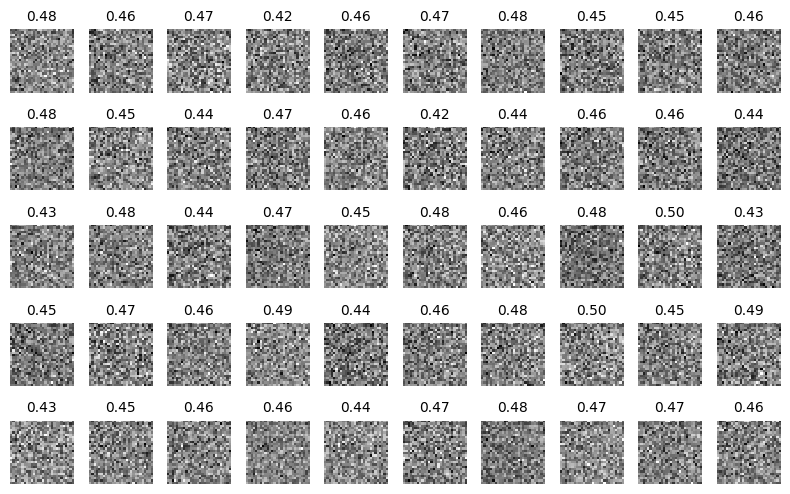

--------------- Epoch 1 ---------------


100%|██████████| 546/546 [00:58<00:00,  9.38it/s]


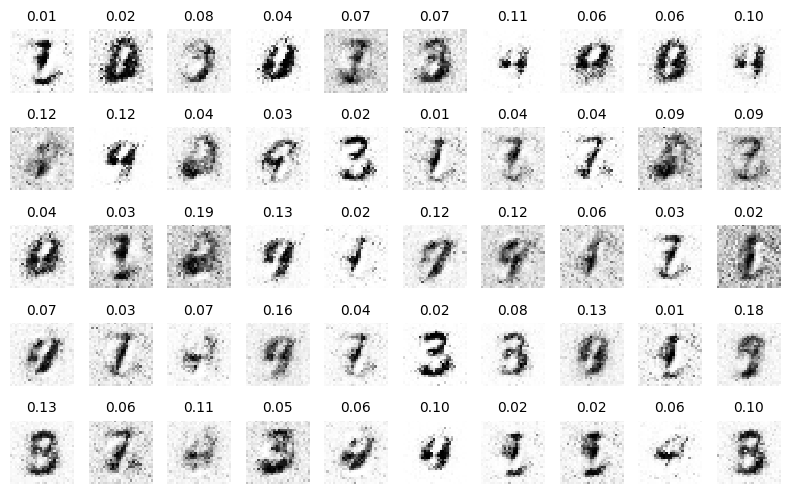

In [17]:
# escolha das épocas e do batch_size para o treinamento da GAN
epochs = 1
batch_size = 128
train(epochs, batch_size)

This code takes less than a minute per epoch on a GPU T4 and that is the main reason this code was selected. You can experiment by using more epochs and by adding more (and different) layers to both the generator and discriminator. However, when using more complex and deep architectures the runtime will also increase if you are using only a CPU. However, do not let that stop you from experimenting!

In [26]:
# aqui temos um treinamento individual, por tamanho do lote (batch_count) e não por épocas
batch_size = 128
batch_ = x_train.shape[0] / batch_size
batch_count = batch_ // 2
#batch_count = 100
print('batch count:', int(batch_count))

for i in tqdm(range(int(batch_count))):
  # Get a random set of input noise and images
  noise = np.random.normal(0, 1, size=[batch_size, random_dim])
  # random batch size set of x_train images
  image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]
  # Generate fake MNIST images
  generated_images = generator.predict(noise, verbose='None')
  X = np.concatenate([image_batch, generated_images])

  # Labels for generated and real data
  y_dis = np.zeros(2*batch_size)
  # One-sided label smoothing
  y_dis[:batch_size] = 1.0

  # Train discriminator
  discriminator.trainable = True
  discriminator.train_on_batch(X, y_dis)

  # Train generator
  noise = np.random.normal(0, 1, size=[batch_size, random_dim])
  y_gen = np.ones(batch_size)
  discriminator.trainable = False
  gan.train_on_batch(noise, y_gen)

batch count: 273


100%|██████████| 273/273 [00:28<00:00,  9.73it/s]


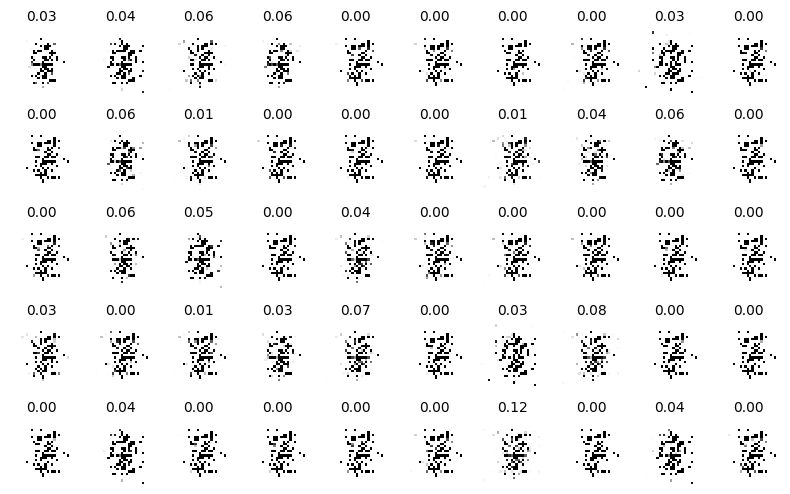

In [27]:
plot_generated_images()

Aqui vamos gerar uma amostra da entrada random da GAN (ruido), plotar a entrada 10 x 10, depois plotar a predição do Gerador (generator), depois plotar a predição do Discrinador (discriminator) na imagem fake e por fim plotar uma imagem aleatória do banco de dados real (x_train) e fazer uma predição com o Discriminador.

random noise shape: (1, 100)


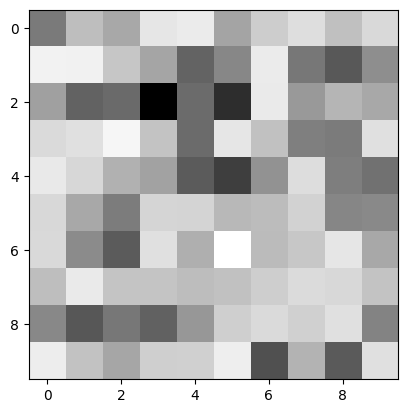


generated images shape: (1, 784)


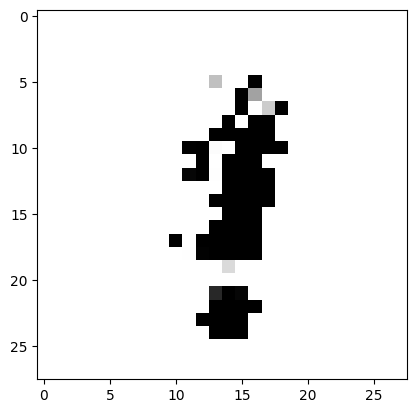

fake image discriminator prediction: [0.45085248]




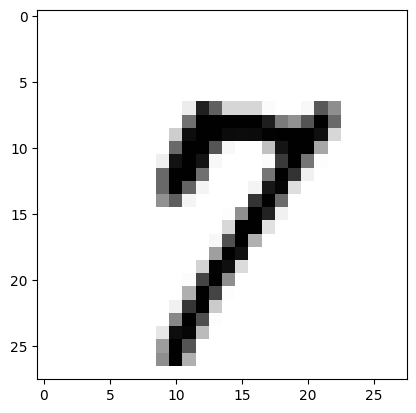

real image discriminator prediction: [0.65878826]


In [44]:
# rotina para plotar e predizer uma amostra
noise = np.random.normal(0, 1, size=[1, random_dim])
print('random noise shape:', noise.shape)
plt.imshow(noise[0].reshape(10,10), cmap='Greys')
#plt.figure(figsize=(1,1))
plt.show()
generated_images = generator.predict(noise, verbose='None')
print('\ngenerated images shape:', generated_images.shape)
plt.imshow(generated_images[0].reshape(28,28), cmap='Greys')
plt.show()
discriminator_predict = discriminator.predict(generated_images, verbose='None')
print('fake image discriminator prediction:', discriminator_predict[0])
#print(gan.predict(noise))
i = np.random.randint(0, x_train.shape[0], size=1)
plt.imshow(x_train[i].reshape(28,28), cmap='Greys')
print('\n')
plt.show()
discr_predict = discriminator.predict(x_train[i], verbose='None')
print('real image discriminator prediction:', discr_predict[0])

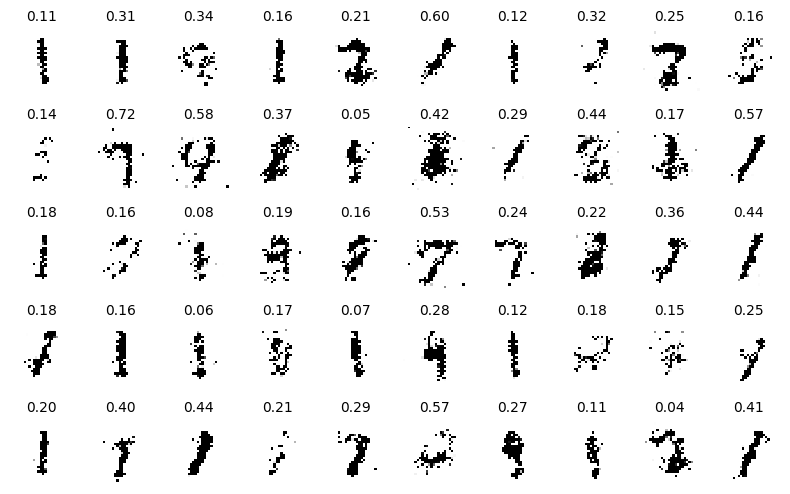

In [45]:
# aqui vamos plotar 50 amostras das imagens geradas (fake) com as predições do discriminador
plot_generated_images()

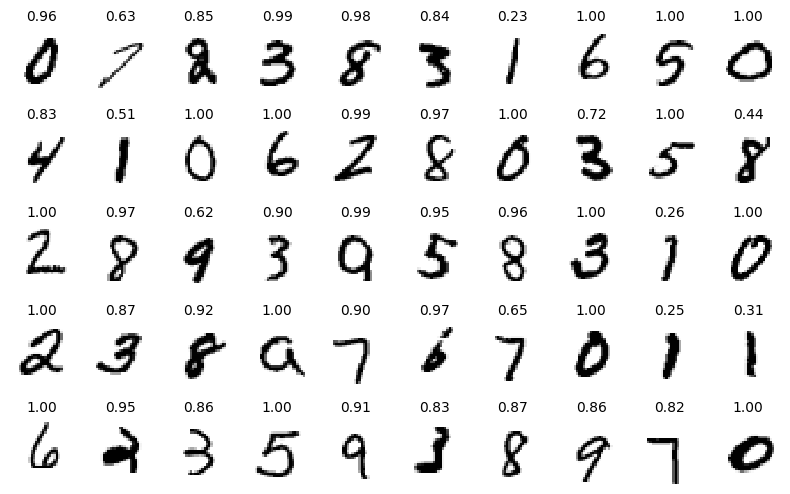

In [46]:
# aqui vamos plotar 50 amostras das imagens reais (x_train) com as predições do discriminador
examples=50
dim=(10, 10)
figsize=(8, 10)

image_batch = x_train[np.random.randint(0, x_train.shape[0], size=examples)]
discr_predict = discriminator.predict(image_batch, verbose='None')
x_images = image_batch.reshape(examples, 28, 28)

plt.figure(figsize=figsize)
for i in range(x_images.shape[0]):
  plt.subplot(dim[0], dim[1], i+1)
  plt.imshow(x_images[i], interpolation='nearest', cmap='gray_r')
  a=discr_predict[i][0]
  fo = "{:.2f}".format(a)
  plt.title(str(fo), fontsize=10)
  plt.axis('off')
plt.tight_layout()
plt.show()

## Conclusão  
Parabéns! Você chegou ao final deste tutorial, no qual aprendeu os conceitos básicos das **Redes Generativas Adversariais (GANs)** de forma intuitiva! Além disso, você implementou seu primeiro modelo com a ajuda da biblioteca Keras.  

As **Redes Generativas Adversariais (GANs)** representam um paradigma poderoso no campo do aprendizado de máquina, oferecendo diversas aplicações e funcionalidades. Esta análise do conteúdo abordou a natureza abrangente das GANs, cobrindo sua definição, aplicações, componentes, metodologias de treinamento, funções de perda, desafios, variações, etapas de implementação e demonstrações práticas. As GANs demonstraram capacidades notáveis na geração de dados realistas, aprimoramento de processamento de imagens e aplicações criativas.  

Apesar de sua eficácia, desafios como **colapso de modos (mode collapse)** e instabilidade no treinamento ainda persistem, exigindo esforços contínuos de pesquisa. No entanto, com o entendimento adequado e uma implementação cuidadosa, as GANs têm um potencial imenso para revolucionar várias áreas, como exemplificado por sua utilização prática em conjuntos de dados como o **MNIST**.  

### Principais Pontos Aprendidos:
1. **O que são GANs**: Uma arquitetura composta por dois modelos (Gerador e Discriminador) que competem entre si para gerar dados realistas.  
2. **Aplicações**: Geração de imagens, vídeos, música, texto e muito mais.  
3. **Componentes**:  
   - **Gerador**: Cria dados a partir de um vetor de ruído.  
   - **Discriminador**: Classifica dados como reais ou falsos.  
4. **Treinamento**: Um processo iterativo onde o Gerador e o Discriminador melhoram continuamente.  
5. **Desafios**: Mode collapse, instabilidade no treinamento e dificuldade de convergência.  
6. **Implementação**: Usando bibliotecas como Keras e TensorFlow para criar e treinar GANs.  

### Próximos Passos:
- Experimente treinar uma GAN em outros conjuntos de dados, como **CIFAR-10** ou **CelebA**.  
- Explore variações avançadas de GANs, como **DCGAN**, **CycleGAN**, ou **StyleGAN**.  
- Aprofunde-se em técnicas para mitigar desafios como mode collapse e instabilidade no treinamento.  

As GANs são uma área emocionante e em constante evolução, com potencial para transformar indústrias e criar novas possibilidades. Continue explorando e experimentando — o céu é o limite!

# Referências

[1] Elgendy, M. *Deep Learning for Vision Systems*. Manning Publications Co. Shelter Island, NY. 2020

[3] [Deep Convolutional Generative Adversarial Network](https://www.tensorflow.org/tutorials/generative/dcgan)

[4] [DCGAN tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)

[5] https://blog.paperspace.com/implementing-gans-in-tensorflow/

[6] https://realpython.com/generative-adversarial-networks/

[7] https://www.datacamp.com/tutorial/generative-adversarial-networks

[8] https://www.analyticsvidhya.com/blog/2021/10/an-end-to-end-introduction-to-generative-adversarial-networksgans/

##Exercícios
1. Analise e comente as linhas de código, comentando e descrevendo os comandos.
1. Altere o learning rate do otimizador e compare os resultados.
1. Altere o otimizador e compare os resultados.
1. Modifique o compilador inserindo o comando *metrics=['accuracy']* para coletar dados para plotar os gráficos de *loss e accuracy*.
1. Utilize o banco de dados MNIST Fashion e verifique o desempenho da rede.
1. Modifique a arquitetura da rede para trabalhar com imagens coloridas. Utilize o banco de dados CIFAR10 e verifque o desempenho da rede.